<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization demo: Masked Autoencoders (MAE)

In this notebook, we are going to visualize some predictions of a Vision Transformer (ViT) pre-trained on a very simple objective, namely masked patch prediction. The model needs to reconstruct pixel values for masked patches (as shown in the figure below).

<img src="https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="600" class="center"/>

* Paper: https://arxiv.org/abs/2111.06377
* Original repo (on which this notebook is based): https://github.com/facebookresearch/mae
* Video explaining the paper: https://www.youtube.com/watch?v=Dp6iICL2dVI 

## Set-up environment

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 11.0 MB/s 
     |████████████████████████████████| 6.8 MB 52.2 MB/s 
     |████████████████████████████████| 895 kB 73.6 MB/s 


## Prepare image

Here we apply some very basic image processing, namely resizing to 224x224 and normalizing the channels.

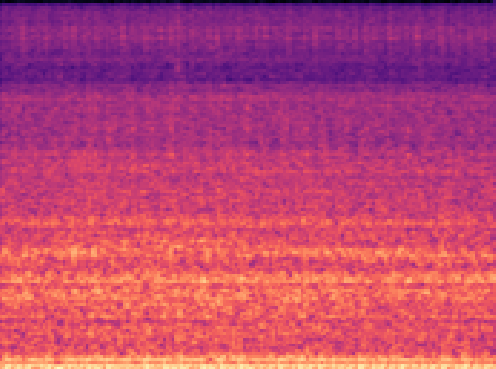

In [5]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
# url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open('audio_transformer/data/train_4/15544-5-0-4.png')
image

In [7]:
pixel_values = feature_extractor(image.convert("RGB"), return_tensors="pt").pixel_values

## Visualization

Next, we forward the pixel values through the model. The encoder (which is a standard Vision Transformer) will first encode the visual patches. Next, a learnable mask token is added at the positions of the masked patches, and the decoder (which is also a Transformer) reconstructs the pixel values based on the encoded visual patches + mask tokens.

The authors saw the best performance when masking out a large portion (75%) of the image patches.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

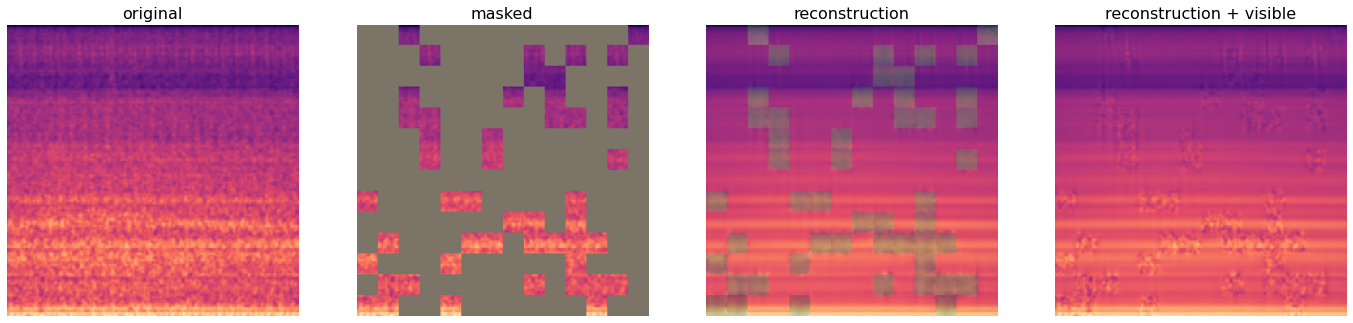

In [8]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)

## After pre-training

Note that, after pre-training, you can directly load the weights of the encoder into a `ViTForImageClassification` and start fine-tuning/doing linear probing. Note that a warning will be printed, indicating that the weights of the decoder aren't used.

In [6]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("facebook/vit-mae-base")

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTForImageClassification: ['decoder.decoder_layers.0.attention.attention.value.weight', 'decoder.decoder_layers.3.output.dense.bias', 'decoder.decoder_layers.5.intermediate.dense.bias', 'decoder.decoder_layers.5.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.4.intermediate.dense.weight', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.1.layernorm_before.bias', 'decoder.decoder_layers.1.attention.attention.key.bias', 'decoder.decoder_layers.2.attention.attention.key.bias', 'decoder.decoder_layers.5.attention.attention.query.bias', 'decoder.decoder_layers.7.layernorm_after.weight', 'decoder.decoder_layers.5.attention.attention.value.weight', 'decoder.de